In [1]:
import os
import datetime

import pandas as pd
import seaborn as sns
from google.colab import drive
import matplotlib.patches as mpatches


drive.mount('/content/drive')
diretorio = '/content/drive/MyDrive/desafio/'

Mounted at /content/drive


#<b>1º Desafio</b> <br>
O gerenciamento do relacionamento com os clientes tem como um dos seus objetivos 
centrais aumentar o número de clientes ativos da empresa - e a retenção desses clientes é crítica 
para seu sucesso. Sendo assim, um time foi mobilizado para garantir o desenvolvimento da 
estratégia de retenção de clientes e, sabendo do seu potencial analítico, você foi convocado para 
esse desafio. 
<p>Em busca de uma maior compreensão das particularidades do negócio e de melhor 
entendimento do cenário do churn, vocês optaram por realizar uma análise exploratória dos 
dados. Em um primeiro momento algumas hipóteses foram levantadas visando direcionar esse 
desenvolvimento inicial e, considerando a base de dados disponibilizada e um período de churn
de 1 ano, foi requisitado a você a validação da seguinte hipótese: 
<p><b>"O churn de novos clientes é maior do que o churn de clientes ativos”</b>

##O que é churn?
<p><i>"O churn é uma métrica que indica a taxa de cancelamento de clientes em um determinado período. Para calculá-lo, você deve levar em consideração dois fatores: o número de cancelamentos e o total de clientes ativos no início do período que você quer analisar. Saiba mais!"</i>
<p><b>Fonte:</b> https://conteudo.movidesk.com/o-que-e-churn-por-que-ele-e-importante/


In [2]:
arquivo = os.path.join(diretorio, 'base_teste.csv')
dados = pd.read_csv(arquivo)
dados.head(10)

,Unnamed: 0,cidade_retirada,cidade_devolucao,cd_contrato,transporte_locado,data_abertura_contrato,qtd_diarias,data_fechamento_contrato,qtd_hora_extra,cd_cliente
0,0,Hogsmeade,Hogsmeade,HGM048798,Portal,2015-01-26 05:58:37,1,2015-01-27 05:58:37,0,1
1,1,Springfield,Springfield,SPF030834,Ônibus Escolar,2015-02-05 15:10:19,1,2015-02-06 15:10:19,0,1
2,2,Porto Real,Porto Real,PRL017782,Barco,2015-05-04 20:49:56,1,2015-05-05 20:49:56,0,1
3,3,Basin City,Basin City,SIN042621,1960 Corvette,2015-05-07 07:34:04,1,2015-05-08 07:34:04,0,1
4,4,Godric's Hollow,Godric's Hollow,GDH044954,Testralio,2015-08-01 11:14:48,2,2015-08-03 12:14:48,1,1
5,5,Springfield,Springfield,SPF003764,Elec-Taurus,2015-09-03 19:19:21,5,2015-09-08 19:19:21,0,1
6,6,South Park,South Park,STP028425,Patins,2016-02-08 00:50:19,2,2016-02-10 00:50:19,0,1
7,7,Godric's Hollow,Godric's Hollow,GDH007992,Vassoura,2016-02-10 23:26:38,3,2016-02-14 00:26:38,1,1
8,8,Ottery St. Catchpole,Ottery St. Catchpole,OSC053048,Rede de Flu,2016-02-20 08:55:55,1,2016-02-21 08:55:55,0,1
9,9,Springfield,Springfield,SPF024515,Ford LTD Crown Victoria,2016-03-03 23:24:41,1,2016-03-04 23:24:41,0,1


In [3]:
dados.drop(columns=dados.columns[0],inplace=True)


In [4]:
#Estatisticas basicas.
dados.describe()

,qtd_diarias,qtd_hora_extra,cd_cliente
count,480863.000000,480863.000000,480863.000000
mean,2.466301,0.110892,10208.952648
std,1.892560,0.350490,10070.974135
min,1.000000,0.000000,1.000000
25%,1.000000,0.000000,2976.000000
50%,2.000000,0.000000,7145.000000
75%,3.000000,0.000000,14186.000000
max,26.000000,6.000000,123883.000000


In [5]:
#Total de clientes
total_clientes = dados.cd_cliente.value_counts().count()
total_clientes

44842

In [6]:
#Verificando se existe valores nulos na base
dados.isna().sum()

cidade_retirada             0
cidade_devolucao            0
cd_contrato                 0
transporte_locado           0
data_abertura_contrato      0
qtd_diarias                 0
data_fechamento_contrato    0
qtd_hora_extra              0
cd_cliente                  0
dtype: int64

In [7]:
#Verificando tipos de dados
dados.dtypes

cidade_retirada             object
cidade_devolucao            object
cd_contrato                 object
transporte_locado           object
data_abertura_contrato      object
qtd_diarias                  int64
data_fechamento_contrato    object
qtd_hora_extra               int64
cd_cliente                   int64
dtype: object

In [8]:
#Convertendo de object para datetime
dados.data_abertura_contrato = dados.data_abertura_contrato.apply(datetime.datetime.fromisoformat)
dados.data_fechamento_contrato = dados.data_fechamento_contrato.apply(datetime.datetime.fromisoformat)
dados['ano_abertura'] = dados.data_abertura_contrato.apply(lambda x: x.year).astype(int)

In [9]:
#Agregando valores
compras_clientes = dados.groupby(['cd_cliente'], as_index=False).agg(n_contratos = ('cd_contrato','count'), 
                                                                     ultima_abertura =('data_abertura_contrato','max'),
                                                                     primeira_abertura = ('data_abertura_contrato','min'),
                                                                     ano_primeira_abertura = ('ano_abertura', 'min'),
                                                                     ano_ultima_abertura = ('ano_abertura', 'max'))


In [10]:
compras_clientes

,cd_cliente,n_contratos,ultima_abertura,primeira_abertura,ano_primeira_abertura,ano_ultima_abertura
0,1,36,2020-10-20 21:26:18,2015-01-26 05:58:37,2015,2020
1,2,43,2020-12-12 05:39:35,2015-01-31 02:29:17,2015,2020
2,3,37,2020-10-31 18:15:45,2015-02-12 09:27:50,2015,2020
3,4,36,2020-12-13 17:31:26,2015-03-06 15:37:42,2015,2020
4,5,49,2020-12-11 08:37:12,2015-02-24 09:00:59,2015,2020
...,...,...,...,...,...,...
44837,109047,1,2020-11-25 20:25:29,2020-11-25 20:25:29,2020,2020
44838,112481,1,2018-03-21 16:10:18,2018-03-21 16:10:18,2018,2018
44839,114109,1,2015-08-11 18:22:46,2015-08-11 18:22:46,2015,2015
44840,121495,1,2015-07-14 02:33:22,2015-07-14 02:33:22,2015,2015


In [11]:
resultado = dados.pivot_table(values='cd_contrato', index='cd_cliente', aggfunc='count',columns='ano_abertura', fill_value=0)
resultado.reset_index(inplace=True)
resultado.head(10)

ano_abertura,cd_cliente,2015,2016,2017,2018,2019,2020
0,1,6,10,4,5,5,6
1,2,10,7,7,3,8,8
2,3,5,5,3,9,7,8
3,4,9,2,2,8,7,8
4,5,10,8,6,9,11,5
5,6,5,7,10,6,8,7
6,7,7,5,3,12,7,10
7,8,7,7,10,6,7,12
8,9,3,6,9,9,4,8
9,10,10,10,7,12,2,9


In [12]:
dados_constratos = pd.merge(compras_clientes, resultado, how='inner',on='cd_cliente')

In [13]:
lista_anos = list(dados_constratos.ano_primeira_abertura.unique())
lista_anos

[2015, 2016, 2017, 2018, 2019, 2020]

In [14]:

for ano in lista_anos:
  dados_constratos['existe_' + str(ano)] = dados_constratos[ano] >0


In [15]:
colunas_validacao = [coluna for coluna in list(dados_constratos.columns) if 'existe_' in str(coluna)]
colunas_validacao

['existe_2015',
 'existe_2016',
 'existe_2017',
 'existe_2018',
 'existe_2019',
 'existe_2020']

In [16]:
#verificando quantidade de anos que cliente realizou compras
dados_constratos['n_anos'] =  dados_constratos[colunas_validacao].sum(axis=1)

In [17]:
#Verificando se existe clientes que ficam mais de um ano sem realizer compras.
dados_constratos[(dados_constratos.n_anos != (dados_constratos.ano_ultima_abertura - dados_constratos.ano_primeira_abertura +1 ) )]

,cd_cliente,n_contratos,ultima_abertura,primeira_abertura,ano_primeira_abertura,ano_ultima_abertura,2015,2016,2017,2018,2019,2020,existe_2015,existe_2016,existe_2017,existe_2018,existe_2019,existe_2020,n_anos
543,544,36,2020-07-20 07:52:57,2015-01-15 00:03:20,2015,2020,11,0,10,5,7,3,True,False,True,True,True,True,5
1617,1618,34,2020-12-27 20:52:08,2015-01-21 22:03:55,2015,2020,9,7,7,0,6,5,True,True,True,False,True,True,5
1773,1774,34,2020-12-02 14:57:06,2015-04-10 22:19:06,2015,2020,5,0,9,5,10,5,True,False,True,True,True,True,5
1993,1994,24,2020-11-22 06:12:36,2015-03-13 20:18:04,2015,2020,6,4,4,0,3,7,True,True,True,False,True,True,5
2149,2150,35,2020-10-31 15:13:55,2015-02-03 21:58:05,2015,2020,9,7,0,5,5,9,True,True,False,True,True,True,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44245,66262,2,2020-08-23 06:25:06,2015-03-22 19:01:18,2015,2020,1,0,0,0,0,1,True,False,False,False,False,True,2
44253,66386,2,2019-04-19 19:48:42,2016-09-26 18:33:23,2016,2019,0,1,0,0,1,0,False,True,False,False,True,False,2
44275,66723,2,2020-01-21 15:42:06,2017-09-21 14:55:43,2017,2020,0,0,1,0,0,1,False,False,True,False,False,True,2
44300,67119,2,2020-06-30 08:14:46,2017-09-14 16:49:03,2017,2020,0,0,1,0,0,1,False,False,True,False,False,True,2


Counclusão: Um numero significativo de clientes da base ativa deixa de fazer compras por mais de um ano

##Definição de conceitos:

Após a análise dos dados defini os seguintes conceitos:

<b>Cliente Novo:</b> Cliente será considerado novo no ano do seu primeiro contratos.

<b>Cliente Ativo:</b> Todo cliente na base que é diferente de novo.

<b>Churn Cliente Novo:</b> Cliente novo que realizou apenas uma compra no ano corrente e não realizou compra no ano seguinte.

<b>Churn Cliente Ativo:</b> Cliente ativo que não realizou compra no ano corrente.


In [18]:
dados_constratos.describe()

,cd_cliente,n_contratos,ano_primeira_abertura,ano_ultima_abertura,2015,2016,2017,2018,2019,2020,n_anos
count,44842.000000,44842.000000,44842.000000,44842.000000,44842.000000,44842.000000,44842.000000,44842.000000,44842.000000,44842.000000,44842.000000
mean,24174.058963,10.723496,2015.934080,2019.084675,1.787744,1.780362,1.784688,1.788435,1.795549,1.786718,3.605236
std,16103.161531,12.081304,1.428438,1.414840,2.340669,2.343278,2.335320,2.336435,2.350404,2.322344,1.995501
min,1.000000,1.000000,2015.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,11211.250000,2.000000,2015.000000,2019.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,22429.500000,5.000000,2015.000000,2020.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000
75%,34477.750000,16.000000,2016.000000,2020.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,6.000000
max,123883.000000,66.000000,2020.000000,2020.000000,18.000000,16.000000,18.000000,16.000000,17.000000,17.000000,6.000000


In [19]:
dados_constratos.ano_primeira_abertura.value_counts()

2015    26892
2016     6852
2017     4092
2018     2935
2019     2310
2020     1761
Name: ano_primeira_abertura, dtype: int64

In [20]:
dados_constratos

,cd_cliente,n_contratos,ultima_abertura,primeira_abertura,ano_primeira_abertura,ano_ultima_abertura,2015,2016,2017,2018,2019,2020,existe_2015,existe_2016,existe_2017,existe_2018,existe_2019,existe_2020,n_anos
0,1,36,2020-10-20 21:26:18,2015-01-26 05:58:37,2015,2020,6,10,4,5,5,6,True,True,True,True,True,True,6
1,2,43,2020-12-12 05:39:35,2015-01-31 02:29:17,2015,2020,10,7,7,3,8,8,True,True,True,True,True,True,6
2,3,37,2020-10-31 18:15:45,2015-02-12 09:27:50,2015,2020,5,5,3,9,7,8,True,True,True,True,True,True,6
3,4,36,2020-12-13 17:31:26,2015-03-06 15:37:42,2015,2020,9,2,2,8,7,8,True,True,True,True,True,True,6
4,5,49,2020-12-11 08:37:12,2015-02-24 09:00:59,2015,2020,10,8,6,9,11,5,True,True,True,True,True,True,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44837,109047,1,2020-11-25 20:25:29,2020-11-25 20:25:29,2020,2020,0,0,0,0,0,1,False,False,False,False,False,True,1
44838,112481,1,2018-03-21 16:10:18,2018-03-21 16:10:18,2018,2018,0,0,0,1,0,0,False,False,False,True,False,False,1
44839,114109,1,2015-08-11 18:22:46,2015-08-11 18:22:46,2015,2015,1,0,0,0,0,0,True,False,False,False,False,False,1
44840,121495,1,2015-07-14 02:33:22,2015-07-14 02:33:22,2015,2015,1,0,0,0,0,0,True,False,False,False,False,False,1


In [21]:
dict_item = {}
for ano in lista_anos:
  dict_item.setdefault(ano, {'novo' : 0,
   'ativo' : 0,
   'churn_novo' : 0,
   'churn_ativo': 0})
  
dict_item

{2015: {'ativo': 0, 'churn_ativo': 0, 'churn_novo': 0, 'novo': 0},
 2016: {'ativo': 0, 'churn_ativo': 0, 'churn_novo': 0, 'novo': 0},
 2017: {'ativo': 0, 'churn_ativo': 0, 'churn_novo': 0, 'novo': 0},
 2018: {'ativo': 0, 'churn_ativo': 0, 'churn_novo': 0, 'novo': 0},
 2019: {'ativo': 0, 'churn_ativo': 0, 'churn_novo': 0, 'novo': 0},
 2020: {'ativo': 0, 'churn_ativo': 0, 'churn_novo': 0, 'novo': 0}}

In [22]:
#atribuindo informação de ativos, novos e churn
for linha in dados_constratos.itertuples():
  temp_ano =  {2015: linha._7,
            2016: linha._8,
            2017: linha._9,
            2018: linha._10,
            2019: linha._11,
            2020: linha._12}
  for ano in lista_anos:
    dict_item.setdefault(ano, {})

    #Validade se e novo ou ativo naquele ano.
    if ano == linha.ano_primeira_abertura:
      dict_item[ano]['novo'] += 1
      novo = True
    elif ano > linha.ano_primeira_abertura:
      novo = False
      dict_item[ano]['ativo'] += 1
    else:
      continue

    #verifica se e um chrun
    proximo_ano = ano
    if ano < 2020:
      proximo_ano = ano +1      
    if novo and temp_ano[proximo_ano] == 0 and temp_ano[ano] == 1:
      dict_item[ano]['churn_novo'] += 1
    elif temp_ano[proximo_ano] == 0:
      dict_item[ano]['churn_ativo'] += 1

In [23]:
dados_churn = pd.DataFrame.from_dict(dict_item, orient='index')
dados_churn

,novo,ativo,churn_novo,churn_ativo
2015,26892,0,4982,1981
2016,6852,26892,3303,7604
2017,4092,33744,2511,11233
2018,2935,37836,1967,14107
2019,2310,40771,1735,16077
2020,1761,43081,0,17812


In [24]:
#Calculando Percentual de churn
dados_churn['per_churn_novo'] =  dados_churn.churn_novo / dados_churn.novo * 100
dados_churn['per_churn_ativo'] =  dados_churn.churn_ativo / dados_churn.ativo * 100
dados_churn['per_churn_total'] =  (dados_churn.churn_ativo + dados_churn.churn_novo ) / (dados_churn.ativo+ dados_churn.novo) * 100
dados_churn.iloc[:1,5] = 0

In [25]:
dados_churn

,novo,ativo,churn_novo,churn_ativo,per_churn_novo,per_churn_ativo,per_churn_total
2015,26892,0,4982,1981,18.525956,0.000000,25.892459
2016,6852,26892,3303,7604,48.204904,28.276067,32.322783
2017,4092,33744,2511,11233,61.363636,33.288881,36.325193
2018,2935,37836,1967,14107,67.018739,37.284597,39.425082
2019,2310,40771,1735,16077,75.108225,39.432440,41.345373
2020,1761,43081,0,17812,0.000000,41.345373,39.721689


In [26]:
sns.set_palette("BuPu_r")
sns.set_style("white")

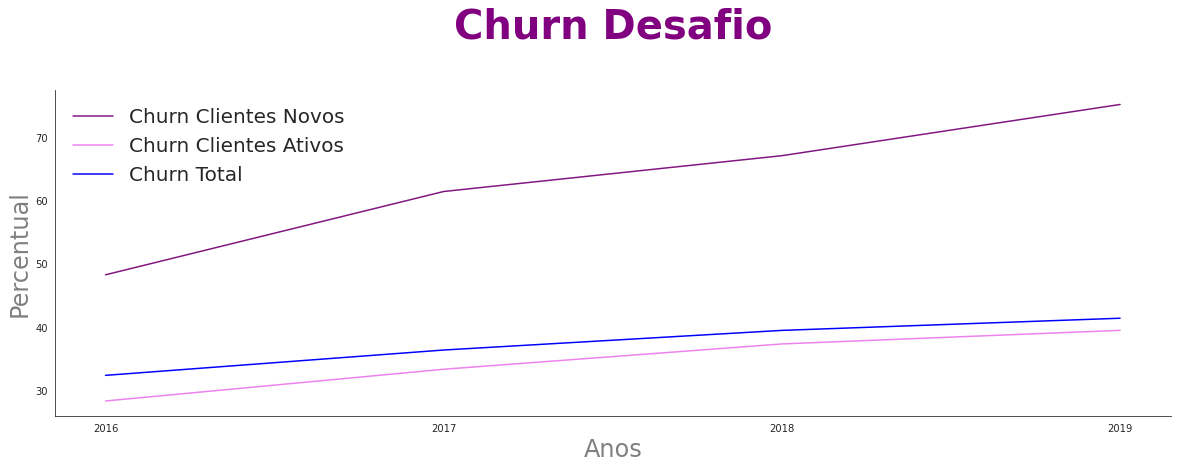

In [29]:
dados_gradico = dados_churn[1:-1]

ax = sns.lineplot( x=dados_gradico.index ,y=dados_gradico.per_churn_novo)
ax1 = sns.lineplot( x=dados_gradico.index, y=dados_gradico.per_churn_ativo, color='violet',)
ax2 = sns.lineplot( x=dados_gradico.index, y=dados_gradico.per_churn_total, color='blue')
ax.set_title('Churn Desafio\n', fontsize=40, fontweight='bold', color='purple')
ax.legend(['Churn Clientes Novos', 'Churn Clientes Ativos', 'Churn Total'], frameon=False, fontsize=20)
ax.figure.set_size_inches(20, 6)
ax.set(xticks=(2016,2017,2018,2019))
ax.set_ylabel('Percentual', fontsize=24, color='grey')
ax.set_xlabel('Anos', fontsize=24, color='grey')
sns.despine()

In [31]:
from scipy.stats import chisquare

In [42]:
chi_2, p_valor = chisquare(f_obs=dados_gradico.per_churn_ativo, f_exp=dados_gradico.per_churn_novo)
confianca = 0.95
significancia = 1-confianca

In [45]:
if p_valor <= significancia:
  print('Rejeita H0')
else:
  print('Aceita H1')

Rejeita H0


<b>Conclusão:</b> Com um nível de confiança de 95% rejeitamos a hipótese nula (H0) que as amostras são iguais. Logo podemos concluir que o churn de novos clientes é maior que dos Ativos.